### Notebook to be used to perform manual focus testing using ACCS Images

In [1]:
import numpy as np
#from lsst.ts import salobj
import asyncio
from astropy.io import fits

import warnings
#import matplotlib.pyplot as plt  # imported as py above
from astropy.modeling import models, fitting
from scipy.ndimage.filters import gaussian_filter as gauss_filt
from matplotlib import pyplot as plt

import copy
from pathlib import Path

In [2]:
import numpy as np
import logging
logger = logging.getLogger('calc_CofM_logger')

def calc_CofM(array, offset=(0,0)):
    # Function takes a a 2d Array and computes the CofM
    
    # offset is the coordinate of the minimum y and x pixel
    
    
    #just make it easier to parse the code below
    shape=array.shape
        
    # Build 2d index arrays for calculations
    pix_index_1d_arr=np.arange(0, shape[0], 1)+ offset[0]
    ones_array_2d=np.ones([shape[1], shape[0]])
    y_index_arr_2d=np.transpose(pix_index_1d_arr*ones_array_2d)
    
    # Can't just use the transpose of the y_index_arr_2d
    # since we're supporting non-symmetrical arrays
    pix_index_1d_arr=np.arange(0, shape[1], 1) + offset[1]
    ones_array_2d=np.ones([shape[0], shape[1]])
    # array will be left to right so need to transpose
    x_index_arr_2d=pix_index_1d_arr*ones_array_2d

    # Calculate the centroid
    y_CofM = np.sum(y_index_arr_2d*array)/np.sum(array)
    x_CofM = np.sum(x_index_arr_2d*array)/np.sum(array)
    
    logger.info('y_CofM is {}'.format(y_CofM))
    logger.info('x_CofM is {}'.format(x_CofM))

    return(y_CofM, x_CofM)

In [3]:
# Generate a set of test data
if False:
    array_size=(3520, 4656)
    psf_avg_pos = (array_size[0]/5.03, array_size[1]/3.05)
    psf_avg_sigma = float(18) # sigma in pixels
    max_pos_err= float(100.0) # maximum position random error in pixels
    max_sigma_err = float(3) # maximum variation in sigma
    amplitude = float(1000) #amplitude of gaussian
    dark_curr = 100
    n_frames = 11

    # Generate x,y,z data, where z is generated in the loop
    y, x = np.mgrid[:array_size[0], :array_size[1]]

    for n in np.arange(0,n_frames):
        # create base detector array
        im0 = np.zeros((array_size))+dark_curr
        # make Z array
        z=copy.deepcopy(im0)

        # put random offsets on parameters
        xoffset = max_pos_err*np.random.random()
        yoffset = max_pos_err*np.random.random()
        stddev_offset = max_sigma_err*np.random.random()

        # create data using astropy.modeling
        psf = models.Gaussian2D.evaluate(x,y, amplitude=amplitude, x_mean=psf_avg_pos[1]+xoffset,
                               y_mean=psf_avg_pos[0]+yoffset, 
                               x_stddev=psf_avg_sigma+stddev_offset,
                               y_stddev=psf_avg_sigma+stddev_offset,
                               theta=0.0)

        #add shot noise
        #psf+= (np.sqrt(psf)*np.random.randn(array_size[0], array_size[1]))

        # Display image?
        if False:
            fig2, ax2 = plt.subplots(figsize=(7,6))
            ax2.imshow(psf, interpolation='none')

        # Write the fits files
        hdu=None
        hdu = fits.PrimaryHDU(psf)
        hdul = fits.HDUList([hdu])
        fname = '20190910-generated-psf'+str(n)+'.fits'
        output_folder = Path("/home/saluser/data/20190910")
        print('writing psf file {}'.format(fname))
        hdul.writeto(output_folder / fname, overwrite=True)

In [4]:
np.random.random((1,2))

array([[0.1913688 , 0.24761617]])

In [5]:
import os
os.environ["LSST_DDS_DOMAIN"]
import sys
import logging
import asyncio
from lsst.ts import salobj
import wget

In [7]:
d = salobj.Domain()
gencam = salobj.Remote(d, 'GenericCamera', index=1)
await gencam.start_task

In [8]:
gencam.cmd_setLogLevel.set(level=logging.DEBUG)

True

In [9]:
# Get summary state
print(salobj.State(gencam.evt_summaryState.get().summaryState))

State.ENABLED


In [244]:
# r.evt_endReadout.flush()
await gencam.cmd_takeImages.set_start(numImages=1, expTime=2., shutter=True, imageSequenceName='bet_grus')

tmp = await gencam.evt_endReadout.next(flush=False, timeout=1)
tmp = gencam.evt_endReadout.get()
print(tmp.imageName)

RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 12 messages


1325434633-bet_grus-0-1


In [233]:
wget_url = 'http://192.168.1.216:8000/'+tmp.imageName+'.fits'
print(wget_url)

http://192.168.1.216:8000/1325431876-bet_grus-0-1.fits


In [234]:
filename = wget.download(wget_url)
print('Grabbed/Wrote {} via wget'.format(filename))

Grabbed/Wrote 1325431876-bet_grus-0-1.fits via wget


In [235]:
# Declare where data is located and where output will be written, notably the stacked images
data_folder = Path("/home/saluser/develop/ts_notebooks/pingraham/summit_notebooks/AT_201909")
output_folder = Path("/home/saluser/data/output")

In [236]:
im=(fits.open(data_folder / filename))[0].data

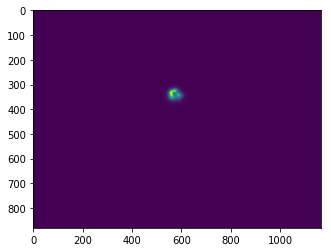

In [237]:
if True:
    im_sub=im-np.median(im)
    plt.imshow(im_sub)

In [238]:
# Find star by convolution with gaussian, then grab the max
tmp=gauss_filt(im,[5,5],mode='constant',cval=0)
print(np.max(tmp))
value=None
ind=np.argmax(tmp)
ind2d = np.unravel_index(ind,tmp.shape)
print('centroid at y,x: {} {}'.format(ind2d[0],ind2d[1]))
ind2d0=copy.deepcopy(ind2d)

#ymin=1800 ; ymax=2048
#xmin=280 ; xmax=450
half_side=int(100)
ymin = ind2d[0]-half_side if ind2d[0]-half_side > 0 else 0
ymax = ind2d[0]+half_side if ind2d[0]+half_side < im.shape[0] else im.shape[1]
xmin = ind2d[1]-half_side if ind2d[1]-half_side > 0 else 0
xmax = ind2d[1]+half_side if ind2d[1]+half_side < im.shape[1] else im.shape[1]
print('subimage being made from ymin,ymax,xmin,xmax:{} {} {} {}'.format(ymin,ymax,xmin,xmax))
# new maximum at:
ind=np.argmax(tmp[ymin:ymax,xmin:xmax])
ind2d = np.unravel_index(ind,tmp[ymin:ymax,xmin:xmax].shape)
print('new centroid at y,x: {} {}'.format(ind2d[0],ind2d[1]))

14864
centroid at y,x: 335 559
subimage being made from ymin,ymax,xmin,xmax:235 435 459 659
new centroid at y,x: 100 100


In [239]:
im.shape
yoffset_pix=im.shape[0]/2 - ind2d0[0]
xoffset_pix=im.shape[1]/2 - ind2d0[1]
print('yoffset = {} pixels'.format(yoffset_pix))
print('xoffset = {} pixels'.format(xoffset_pix))

yoffset = 105.0 pixels
xoffset = 23.0 pixels


In [240]:
binning=4
plate_scale = 0.1 *1000 # um/arcsec
pix_scl = 3.6*binning # um/pix

yoffset_as = yoffset_pix * pix_scl / plate_scale
xoffset_as = xoffset_pix * pix_scl / plate_scale
print('yoffset is {} arcsec'.format(yoffset_as))
print('xoffset is {} arcsec'.format(xoffset_as))

yoffset is 15.12 arcsec
xoffset is 3.312 arcsec


18584.0


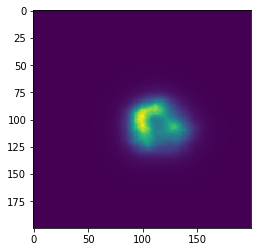

In [241]:
im_sub=im[ymin:ymax,xmin:xmax]
im_sub=im_sub-np.median(im_sub)
plt.imshow(im_sub)
print(np.nanmax(im_sub))

18584.0


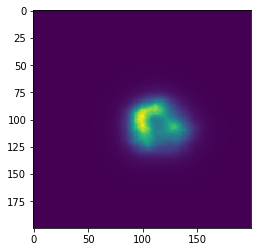

In [242]:
im_sub=im[ymin:ymax,xmin:xmax]
im_sub=im_sub-np.median(im_sub)
plt.imshow(im_sub)
print(np.nanmax(im_sub))

100
100


Text(0.5, 1.0, 'Residual')

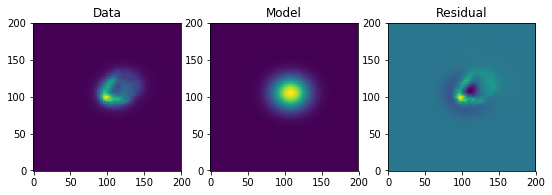

In [198]:
# Generate x,y,z data
y, x = np.mgrid[:im_sub.shape[0], :im_sub.shape[1]]
print(y[ind2d])
print(x[ind2d])
z=im_sub
# Fit the data using astropy.modeling
p_init = models.Gaussian2D(amplitude=np.nanmax(z),x_mean=x[ind2d], y_mean=y[ind2d], fixed={'theta':True})
#p_init = models.Gaussian2D(amplitude=np.nanmax(z),x_mean=38, y_mean=51, x_stddev=3, y_stddev=3,  fixed={'theta':True})
fit_p = fitting.LevMarLSQFitter()

with warnings.catch_warnings():
    # Ignore model linearity warning from the fitter
    warnings.simplefilter('ignore')
    p = fit_p(p_init, x, y, z)

# Plot the data with the best-fit model
plt.figure(figsize=(9, 5))
plt.subplot(1, 3, 1)
plt.imshow(z, origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(x, y), origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(z - p(x, y), origin='lower', interpolation='nearest')#, vmin=-1e4, vmax=5e4)
plt.title("Residual")

In [199]:
repr(p)

'<Gaussian2D(amplitude=15891.64143355, x_mean=108.27275112, y_mean=105.04175138, x_stddev=16.92543918, y_stddev=14.71998924, theta=0.)>'

In [200]:
print('{}, {}, {}'.format(psf_fname, p.x_stddev.value, p.y_stddev.value))

1325429366-bet_grus-0-1.fits, 16.925439176728673, 14.719989238436273


In [ ]:
# hexapod Z, filename, xsttd, ystddev
# 0.300, 1325429366-bet_grus-0-1.fits, 20.17756577291818, 18.49931466099071
# 0.032, 1325429366-bet_grus-0-1.fits, 18.605872647081075, 14.995560001304131
# 0.33, 1325429366-bet_grus-0-1.fits, 17.535626208313843, 15.471926526885643
# 0.35, 1325429366-bet_grus-0-1.fits, 16.925439176728673, 14.719989238436273
# 0.34, 


In [42]:
# Make an radial plot
pix_index_1d_arr=np.arange(0,2*half_side,1)
ones_array_2d=np.ones([2*half_side,2*half_side])
#print(x_arr)
#print(tmp)
x_index_arr_2d=pix_index_1d_arr*ones_array_2d
x_arr_2d=x_index_arr_2d - p.x_mean.value
y_arr_2d= np.transpose(x_index_arr_2d) - p.y_mean.value
# create array of radial distances (in pixels)
r_arr_2d=np.sqrt(x_arr_2d**2 + y_arr_2d**2)

In [39]:
if False:
    plt.imshow(r_arr_2d)
    plt.colorbar()

In [40]:
r_arr_1d=np.reshape(r_arr_2d,(2*half_side)**2)
values = np.reshape(z,(2*half_side)**2)

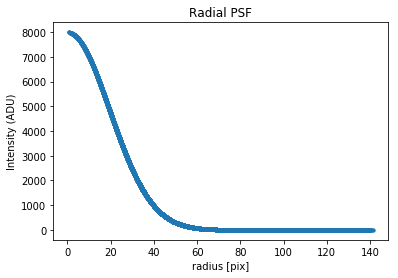

In [41]:
if True:
    plt.ylabel('Intensity (ADU)')
    plt.plot(r_arr_1d, values,'.')
    plt.title('Radial PSF')
    plt.xlabel('radius [pix]')
    plt.show()
    plt.close()